### Scraping data from Skytrax

Data source: [ https://www.airlinequality.com/airline-reviews/british-airways ]

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 20
page_size = 200

reviews = []

# Scraping reviews from multiple pages
for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 200 total reviews
Scraping page 2
   ---> 400 total reviews
Scraping page 3
   ---> 600 total reviews
Scraping page 4
   ---> 800 total reviews
Scraping page 5
   ---> 1000 total reviews
Scraping page 6
   ---> 1200 total reviews
Scraping page 7
   ---> 1400 total reviews
Scraping page 8
   ---> 1600 total reviews
Scraping page 9
   ---> 1800 total reviews
Scraping page 10
   ---> 2000 total reviews
Scraping page 11
   ---> 2200 total reviews
Scraping page 12
   ---> 2400 total reviews
Scraping page 13
   ---> 2600 total reviews
Scraping page 14
   ---> 2800 total reviews
Scraping page 15
   ---> 3000 total reviews
Scraping page 16
   ---> 3200 total reviews
Scraping page 17
   ---> 3400 total reviews
Scraping page 18
   ---> 3600 total reviews
Scraping page 19
   ---> 3800 total reviews
Scraping page 20
   ---> 3944 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | I know BA often comes under ...
1,✅ Trip Verified | My recent experience with...
2,Not Verified | This recent long-haul experien...
3,✅ Trip Verified | Check-in was slow with onl...
4,Not Verified | Check in was smooth enough. Bo...


In [4]:
df.to_csv("BA_reviews.csv")

## Clean Data

In [5]:
df = pd.read_csv('BA_reviews.csv')
df.head(10)

,Unnamed: 0,reviews
0,0,✅ Trip Verified | I know BA often comes under ...
1,1,✅ Trip Verified | My recent experience with...
2,2,Not Verified | This recent long-haul experien...
3,3,✅ Trip Verified | Check-in was slow with onl...
4,4,Not Verified | Check in was smooth enough. Bo...
5,5,✅ Trip Verified | Although transferring to thi...
6,6,✅ Trip Verified | We are extremely grateful ...
7,7,✅ Trip Verified | I had an appalling experie...
8,8,"Not Verified | Good points, the cabin crew, t..."
9,9,"Not Verified | It was a decent flight, reason..."


In [6]:
df.shape

(3944, 2)

## Topic Modeling

In [7]:
## For Topic Modeling Example Reference
# https://medium.com/@conniezhou678/unveiling-the-power-of-topic-modeling-on-text-data-enhancing-insights-with-manual-adjustments-564cee33ee18

In [8]:
# Assuming df is your DataFrame and 'reviews' is the column with text data
# Cleaning text data
df['reviews'] = df['reviews'].astype(str)
df['reviews'] = df['reviews'].str.lower().apply(lambda x: re.sub('[^\w\s]', '', x))
# lambda x: ...: Defines an anonymous function that takes one argument, x. It doesn't have to be x, it can be any other english letter. 
# re.sub('[^\w\s]', '', x): Inside this function, x (the text string) is processed by re.sub:[^\w\s]: Matches any character that is not a word character or a whitespace.
#'': Replaces these matched characters with an empty string (removes them).
# .apply(lambda x: ...): Applies this lambda function to each element in the reviews column of the DataFrame.

stop_words = set(stopwords.words('english'))
additional_stopwords = ['customer','airline', 'flight', 'plane','review','didnt','people','however', 'way', 'ones', 'took', 'used', 'asking', 'back', 'however', 'seat', 'airport', 'board', 'travel', 'trip', 'experience','form', 'usually', 'helped','give','can','usual','online','werent','onto','given','cant','ever','get','verified','could','would','time','told','one','two','three','four','even','us',
                        'presented','second','help','prepared','went','using', 'eventually', 'reviews','wouldnt','got','ba', 'forced', 'getting', 'service', 'staff', 'passenger', 'luggage', 'delay', 'cancellation', 'meal', 'entertainment', 'baggage', 'check-in', 'departure', 'arrival', 'evening', 'via', 'baby', 'use', 'offering','airways','british','offered','asked',]

#Combine the two lists
combined_stopwords = stop_words.union(additional_stopwords)

#Convert the combined stopwords to a list
combined_stopwords_list = list(combined_stopwords)

df['reviews'] = df['reviews'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))


## Sentiment Analysis

In [9]:
from textblob import TextBlob

df['sentiment'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
avg_sentiment = df['sentiment'].mean()
print("Average sentiment polarity:", df['sentiment'].mean())


Average sentiment polarity: 0.09471475937705681


In [10]:
#  the average sentiment polarity is approximately 0.094. This value is slightly above zero, between -1 and 1, 1 being the best. 
#  suggesting that the overall sentiment expressed in the reviews is slightly positive. 

## Topic Modeling

In [11]:

# Vectorizing text data
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words=combined_stopwords_list)

dtm = vectorizer.fit_transform(df['reviews'])

# Fitting LDA model
lda = LDA(n_components=5, random_state=0)
lda.fit(dtm)

# Printing topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    sorted_indices= topic.argsort()[::-1]#sort the topic in descending order. 
    top_indices = sorted_indices[:10] # get the indices of the top 10 words. 
    top_words=[feature_names[i] for i in top_indices]
    top_words_freq=topic[top_indices]
    
    print(f"Topic #{topic_idx+1}:")
    print([feature_names[i] for i in topic.argsort()[-10:]])


/Users/henrylu/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['check'] not in stop_words.
  warnings.warn(


Topic #1:
['poor', 'good', 'heathrow', 'passengers', 'served', 'london', 'aircraft', 'food', 'cabin', 'crew']
Topic #2:
['heathrow', 'economy', 'return', 'pay', 'leg', 'flights', 'food', 'london', 'extra', 'seats']
Topic #3:
['first', 'comfortable', 'boarding', 'excellent', 'cabin', 'lounge', 'club', 'food', 'crew', 'good']
Topic #4:
['passengers', 'london', 'cabin', 'premium', 'food', 'first', 'economy', 'seats', 'business', 'class']
Topic #5:
['another', 'cancelled', 'flights', 'booked', 'delayed', 'day', 'heathrow', 'check', 'hours', 'london']


# Summarizing Topics with Labels
### Based on the interpretations, you might label the topics as follows:

### Topic #1: Check-in and boarding experiences. 
### Topic #2: Positive about lounge and food and crew service. 
### Topic #3: In-flight dining positive experiences in business and first class cabin
### Topic #4: Delays in London Heathrow airport.
### Topic #5: Booking and Service Efficiency issue, negative.


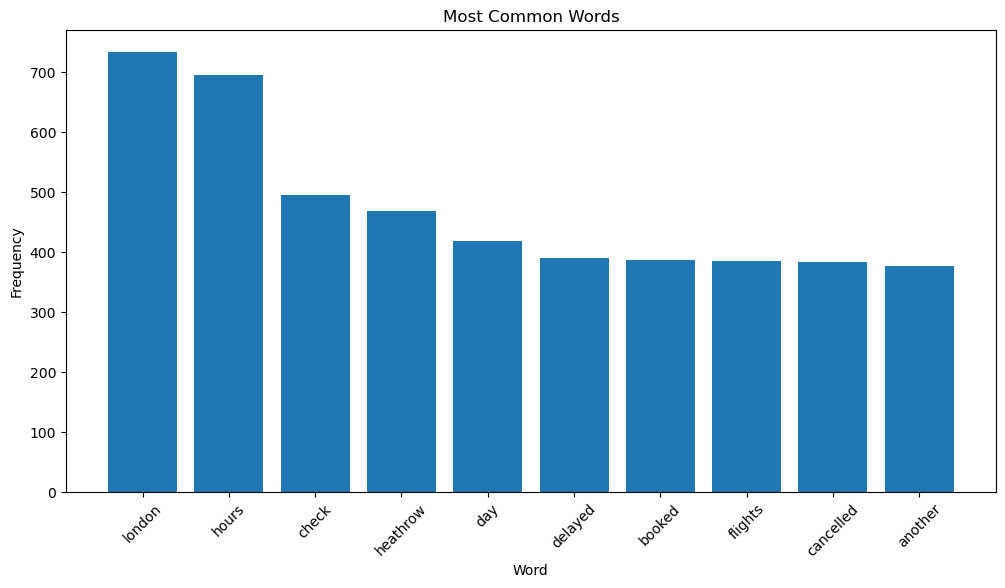

In [12]:
import matplotlib.pyplot as plt
feature_names_df=pd.DataFrame({'Word':top_words,'Frequency':top_words_freq})

# Plot the most common words
plt.figure(figsize=(12, 6))
plt.bar(feature_names_df['Word'], feature_names_df['Frequency'])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()

# Conclusion: 
### Frequent mentions of “delayed,” “hours,” and “Heathrow” indicate frustration. Improve scheduling buffers, increase real-time communication, and work with Heathrow operations to streamline turnaround times

### Topic #1 includes “economy” with words like “good” and “premium,” possibly signaling a comparison. Offer small enhancements in economy (e.g., free snacks, Wi-Fi trials) to boost perception without major cost.

### Customers consistently mention staff friendliness and inflight experience positively.

### Investing in boarding efficiency and airport operations could improve customer satisfaction.

### Maintaining high standards of crew service and lounge experience is key to reinforcing positive brand perception.

    